In [1]:
import os 
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from Code_manual import Coxnnet, PartialNLL
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'd:\\Survival Analysis\\Cox-nnet'

Data Loading

In [3]:
expr_data = pd.read_table("./KIRC_expr.tsv", header=None)
# print(expr_data.shape)   # output : (540,19962)

time_data = pd.read_table("./KIRC_time.tsv", header=None)
# time_data.shape # output : (540,1)

observed_data = pd.read_table("./KIRC_event.tsv", header=None)
# observed_data.shape # output : (540,1)

In [4]:
map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [5]:
X = torch.tensor(np.array(expr_data), dtype=torch.float)
time = torch.tensor(time_data.to_numpy(), dtype=torch.long)
observed = torch.tensor(observed_data.to_numpy(), dtype=torch.float)
train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=25)

train_X = X[train_idx,:]
test_X = X[test_idx,:]

train_time = time[train_idx]
test_time = time[test_idx]

train_observed = observed[train_idx]
test_observed = observed[test_idx]

In [6]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')

Training

In [7]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

class TrainDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(train_X, device=device)
        self.time_data = torch.tensor(train_time, device=device)
        self.observed_data = torch.tensor(train_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
class TestDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(test_X, device=device)
        self.time_data = torch.tensor(test_time, device=device)
        self.observed_data = torch.tensor(test_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
training_data = TrainDataset()
test_data = TestDataset()

train_dataloader = DataLoader(training_data, batch_size = training_data.__len__())
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__())

In [8]:
hidden_dim = 500
model = Coxnnet(train_X.shape[1], hidden_dim)
model = model.to(device)

learning_rate = 10e-5
epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = PartialNLL()

loss_axis = []
cindex_train = []
cindex_test = []

def train_loop(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    for batch, (X, time, observed) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, time, observed)

        # Backpropagation
        optimizer.zero_grad()   # bc/ gradients by default add up; to prevent double counting.
        loss.backward() # deposits gradients
        optimizer.step()    # adjust parameters with gradients
        
        train_perf = 0
        train_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                       event_observed = observed.cpu().detach().numpy(),
                                       predicted_scores = -pred.cpu().detach().numpy())
        
        if ((t+1) % 50 == 0):
            print(f"Epoch {t+1}\n-------------------------------")
            print(f"Train Accuracy: {train_perf}\n")
            print(f"Train Loss: {loss.item()}\n")
        # print(f"Type of loss: {type(loss.item())}") # output: float
        
        loss_axis.append(loss.item())
        cindex_train.append(train_perf)

# iterate over test dataset to check model performance
def test_loop(dataloader, model, t):
    size = len(dataloader.dataset)
    test_perf = 0

    with torch.no_grad():
        for X, time, observed in dataloader:
            pred = model.forward(X)
            # print(f"event_times shape: {time.numpy().shape}")
            # print(f"predicted shape: {pred.numpy().shape}\n")
            test_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                          event_observed = observed.cpu().detach().numpy(),
                                          predicted_scores = -pred.cpu().detach().numpy())

    
    if ((t+1) % 50 == 0):
        print(f"Test Accuracy: {test_perf}\n")
        
    cindex_test.append(test_perf)

In [9]:
for t in range(epochs):
    model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer, t)
    model.eval()    # Turn off dropout
    test_loop(test_dataloader, model, t)

Epoch 50
-------------------------------
Train Accuracy: 0.6397534788170084

Train Loss: 5.205234955112242

Test Accuracy: 0.6736435356625342

Epoch 100
-------------------------------
Train Accuracy: 0.6590565525795573

Train Loss: 5.194932877160037

Test Accuracy: 0.6968282080180325

Epoch 150
-------------------------------
Train Accuracy: 0.7052598937943331

Train Loss: 5.063233277604235

Test Accuracy: 0.7175978103364997

Epoch 200
-------------------------------
Train Accuracy: 0.6972363269894182

Train Loss: 5.10072227224448

Test Accuracy: 0.704556432136532

Epoch 250
-------------------------------
Train Accuracy: 0.7001046552191945

Train Loss: 5.086298823628421

Test Accuracy: 0.7155047496377395

Epoch 300
-------------------------------
Train Accuracy: 0.6702197759603086

Train Loss: 5.176672037587046

Test Accuracy: 0.703992915794558

Epoch 350
-------------------------------
Train Accuracy: 0.6959572076437072

Train Loss: 5.104383013368482

Test Accuracy: 0.70986958621800

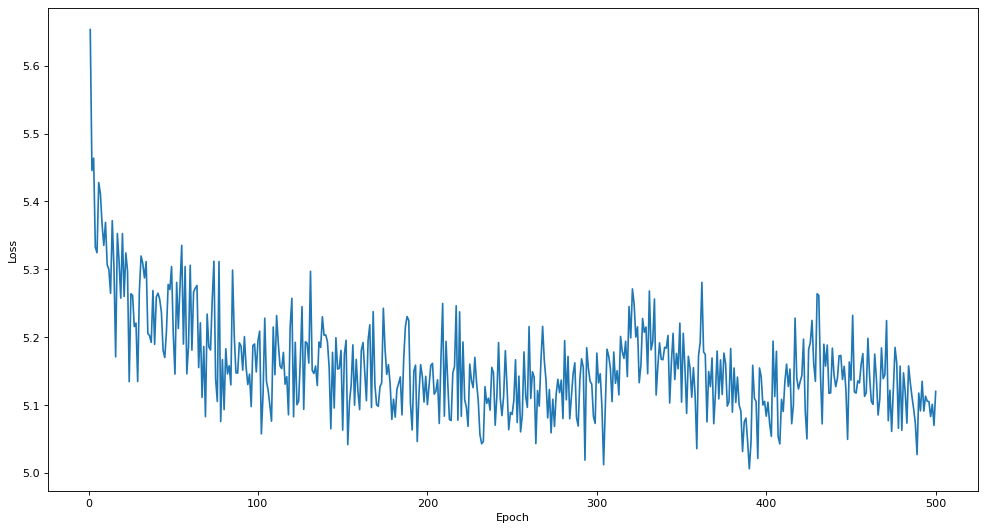

In [10]:
epochs_axis = range(1,epochs+1)

figure(figsize=(15, 8), dpi=80)

plt.plot(epochs_axis, loss_axis)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

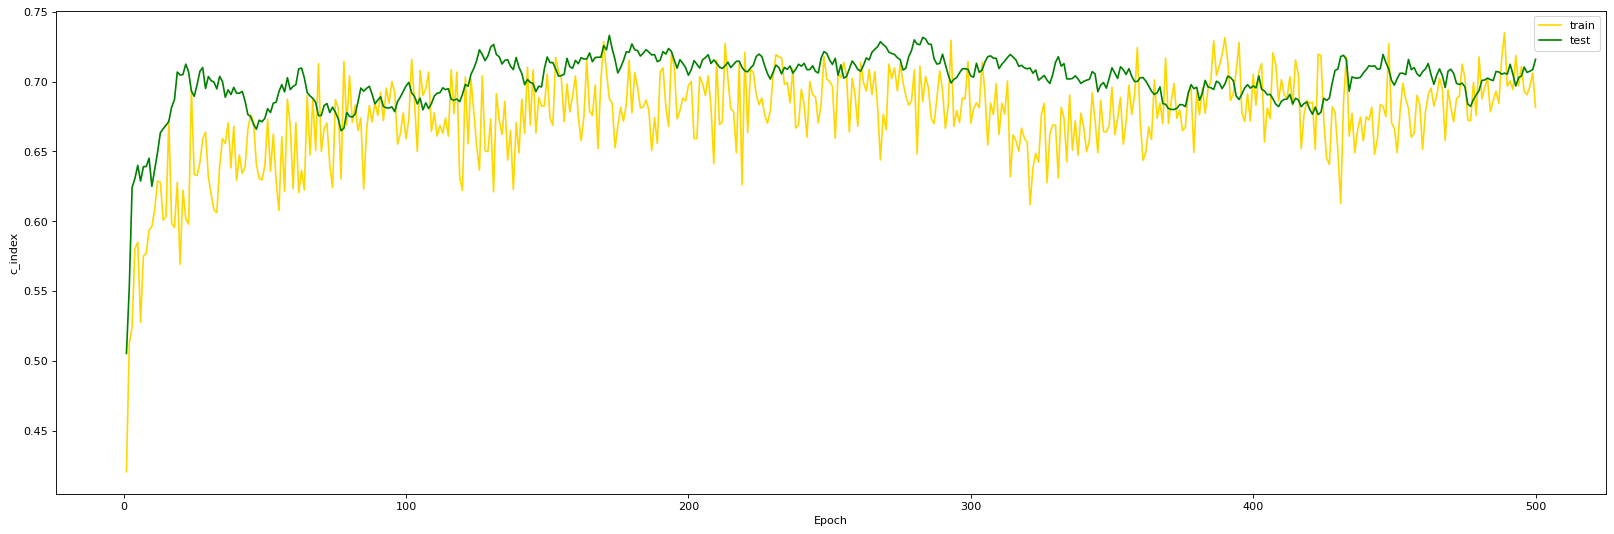

In [11]:
figure(figsize=(25, 8), dpi=80)

plt.plot(epochs_axis, cindex_train, color='gold', label='train')
plt.plot(epochs_axis, cindex_test, color='g', label='test')

plt.xlabel("Epoch")
plt.ylabel("c_index")

plt.legend()

plt.show()